In [8]:
import re
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
#from nltk.tokenize import word_tokenize

import clean_reports
import preprocess_reports



In [14]:
##from sentence_transformers import SentenceTransformer. # will be used for the bert transformer in the future
# dataset location
DATASET = "/Users/jeremygonsalves/Documents/GitHub/PredictingDraftNHL/Data/prospect-data.csv"
print("Dataset saved as DATASET")

# load dataset into dataframe
data = clean_reports.clean(DATASET, raw=True)

data.head()
DATASET=data

#
DATASET2023=data[data['Year'] == 2023]
DATASET2022=data[data['Year'] ==2022]
DATASET2021=data[data['Year'] == 2021]

Dataset saved as DATASET


-----------------
For All Data


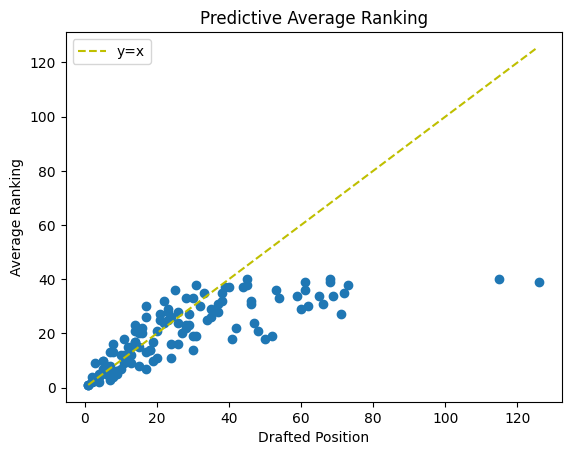

None
-----------------
For 2022


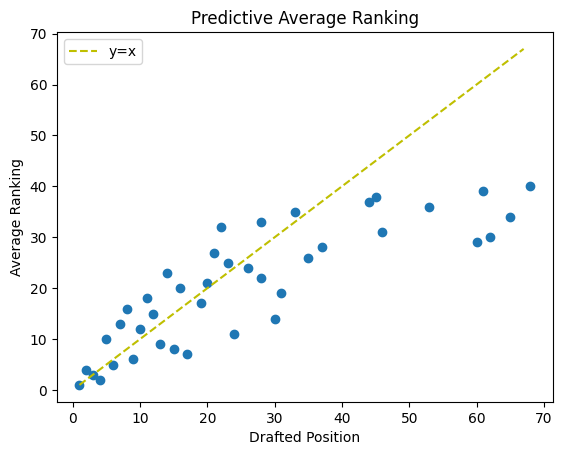

None
-----------------
For 2021


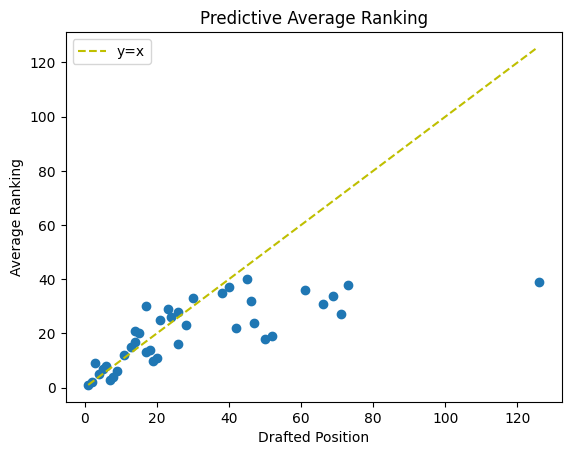

None


In [27]:
def plot_drafted_vs_ranking(data):
    # Create the x-values range from the minimum to the maximum 'Drafted' position
    x = np.arange(data['Drafted'].min(), data['Drafted'].max())     #creates an array of evenly spaced values from min ranked position to max pos
    y = x

    # Scatter plot of 'Drafted' vs 'Average Ranking'
    plt.scatter(data['Drafted'], data['Average Ranking'])

    # Plot a reference line y=x
    plt.plot(x, y, 'y--', label="y=x")
    
    plt.xlabel("Drafted Position")
    plt.ylabel("Average Ranking")
    plt.legend()
    plt.title("Predictive Average Ranking")
    plt.show()

# Now you can call the function with the data you have
print("-----------------")
print("For All Data")
print(plot_drafted_vs_ranking(DATASET))
print("-----------------")
print("For 2022")
print(plot_drafted_vs_ranking(DATASET2022))
print("-----------------")
print("For 2021")
print(plot_drafted_vs_ranking(DATASET2021))

In [28]:
HOCKEY_POSITIONS = {
    'C' : 'Center',
    'D' : 'Defender',
    'RW' : 'Right Wing',
    'LW' : 'Left Wing',
    'G' : 'Goalie'
}

# distribution of player positions
data['Position'].value_counts()

Position
C     134
D     116
RW     78
LW     60
G      14
Name: count, dtype: int64

NameError: name 'scouting_reports' is not defined